# Predicción de tarifas de Uber

El proyecto está basado en un dataset con datos de viajes de Uber, compañía líder en servicios de movilidad alrededor del mundo.
Una de las problemáticas principales es cómo cotizan el valor del viaje en tiempo real, basado en información en tiempo real sobre la oferta y demanda, distancia del viaje, datos históricos y cantidad de pasajeros en menor medida.

El desafío es armar un modelo de predicción de tarifas ya que creemos que esta información es de gran relevancia para el negocio, es un dato clave para el cliente a la hora de tomar la decisión de contratar el servicio.
El análisis estará basado en los datos proporcionados que son los siguientes:

1. Key: identificador de cada viaje

2. fare_amount: tarifa del viaje

3. pickup_datetime: hora y fecha del inicio del viaje

4. pickup_longitude: longitud en el mapa sobre el punto de recogida

5. pickup_latitude: latidud en el mapa sobre el punto de recogida

6. dropoff_longitude: longitud del punto final del viaje

7. dropoff_latitude: latitud del punto final del viaje

8. passenger_count: cantidad de pasajeros


El dataset fue obtenido de Kaggle.
Se realizó una limpieza inicial donde se eliminó una columna que no servía para el análisis.

Obviamente no contaremos con información en tiempo real sobre oferta y demanda, pero tal vez sí podremos estimar demanda combinando datos de horario y pickup.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import boxplot
from seaborn import countplot
from seaborn import distplot
from geopy.geocoders import ArcGIS
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from haversine import haversine
import matplotlib.pyplot as plt
from seaborn import heatmap
geolocator = Nominatim(user_agent="geoapiExercises")
from datetime import *

### Importo el Dataset

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/ezequielimeneses/TrabajoFinalDatascientistCoder/9ce01a9d9600daddcd290ab33e5988ebaaf9f6b0/uber.csv")


### Verifico que se haya cargado bien el dataset

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


### Miro datos básicos de cada columna

In [4]:
df.shape

(200000, 9)

In [5]:
df.count()

Unnamed: 0           200000
key                  200000
fare_amount          200000
pickup_datetime      200000
pickup_longitude     200000
pickup_latitude      200000
dropoff_longitude    199999
dropoff_latitude     199999
passenger_count      200000
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [7]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


La primer conclusión es que tengo las dos variables numéricas ( cantidad de pasajeros y tarifas) y el resto son variables categóricas (latitud y longitud del comienzo y fin de cada viaje). También está la columna date time con la fecha y hora de comienzo del viaje

Se tienen entonces 7 columnas con 199.996 registros (viajes) 

### Elimino la primer columna que no suma para el análisis

In [8]:
df=df.iloc[:,1:]
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


## Ejemplos Análisis univariado 

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='fare_amount'>

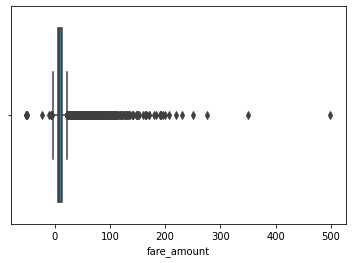

In [9]:
boxplot(df.fare_amount, orient="v",width=0.8,fliersize=5)

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

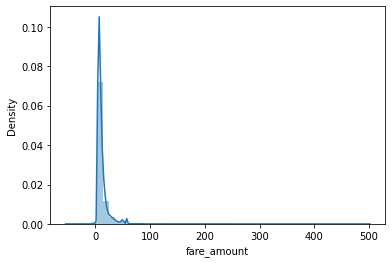

In [10]:
distplot(df.fare_amount)

Cómo se ve gráficamente, hay una dispersión muy grande en los datos. Para hacer un análisis mejor podría quedarme con los registros con tarifa menor a 100 (considerando que estos son los signifactivos)

In [11]:
tarifas_entre0y100=(df.fare_amount<100)&(df.fare_amount>0)

In [12]:
tarifas_entre0y100

0         True
1         True
2         True
3         True
4         True
          ... 
199995    True
199996    True
199997    True
199998    True
199999    True
Name: fare_amount, Length: 200000, dtype: bool

In [13]:
df_tarifas_menores_a_100=df[tarifas_entre0y100]
df_tarifas_menores_a_100.shape

(199888, 8)

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='fare_amount'>

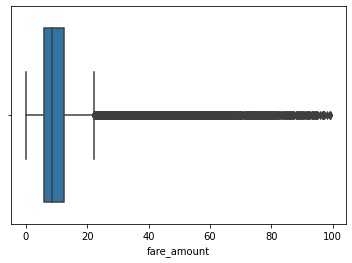

In [14]:
boxplot(df_tarifas_menores_a_100.fare_amount,orient="v")

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

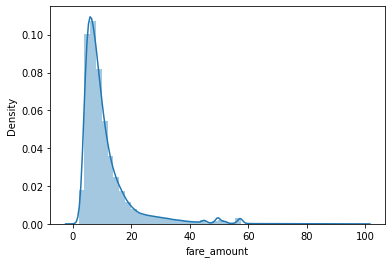

In [15]:
distplot(df_tarifas_menores_a_100.fare_amount)

Perdiendo pocos registros, 111 (0,05% del total inicial), se puede observar mucho mejor la información y hacer un análisis más valioso. Igualmente se sigue viendo, que dentro de ese rango, los datos se encuentran dispersos ya que la frecuencia máxima es un poco más del 10%.

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='passenger_count'>

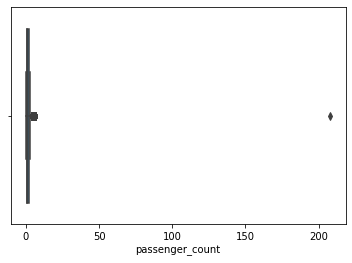

In [16]:
boxplot(df.passenger_count,orient="v")

Lo mismo podemos hacer con esta columna y eliminar el outlier de 200 pasajeros (que no tiene sentido lógico)

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

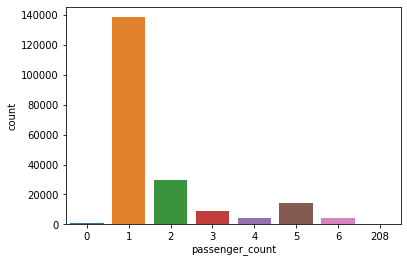

In [17]:
countplot(df.passenger_count)

In [18]:
pasajeros = df.passenger_count<=6

In [19]:
df_sin_208_pasajeros=df[pasajeros]

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='passenger_count', ylabel='count'>

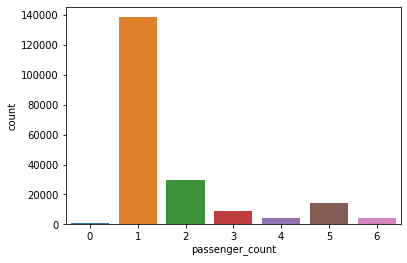

In [20]:
countplot(df_sin_208_pasajeros.passenger_count)

In [21]:
frecuencia_cuenta_pasajeros=df_sin_208_pasajeros.passenger_count.value_counts()
frecuencia_cuenta_pasajeros

1    138425
2     29428
5     14009
3      8881
4      4276
6      4271
0       709
Name: passenger_count, dtype: int64

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='passenger_count'>

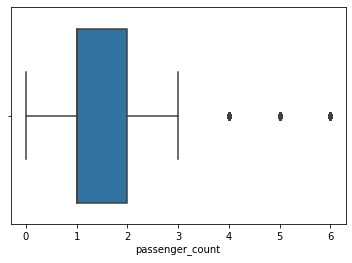

In [22]:
boxplot(df_sin_208_pasajeros.passenger_count,orient="v")

Como vemos, la gran cantidad de viajes fueron con un pasajero. Podemos ver, como tiene sentido, que los viajes fueron desde 1 a 6 pasajeros y habría que seguir averiguando (con el dueño del dataset si esto fuera posible) a que se debe esa cantidad de viajes con 0 pasajeros para ver si se podrían eliminar para no ensuciar la información. 

## Ejemplo Análisis Bivariado 

### Para empezar, planteo dos escenarios que quiero analizar de forma bivariada:
    * Cantidad de pasajeros como variable independiente y tarifa como dependiente
    * Distancia como variable independiente y tarifa como dependiente

#### Genero la distancia haversine entre salida y llegada de cada viaje  

In [23]:
index= df.index
index
distancia=[]
for i in range(len(index)):
    punto_salida=df.pickup_latitude[i],df.pickup_longitude[i]
    punto_llegada=df.dropoff_latitude[i],df.dropoff_longitude[i]
    distancia_viaje=haversine(punto_salida,punto_llegada)
    distancia.append(distancia_viaje)
    distancia

In [24]:
df["distancia_viaje_en_km"]=distancia

In [25]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683325
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457593
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036384
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661686
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475456


Text(0.5, 1.0, 'HeatMap con todas las columnas')

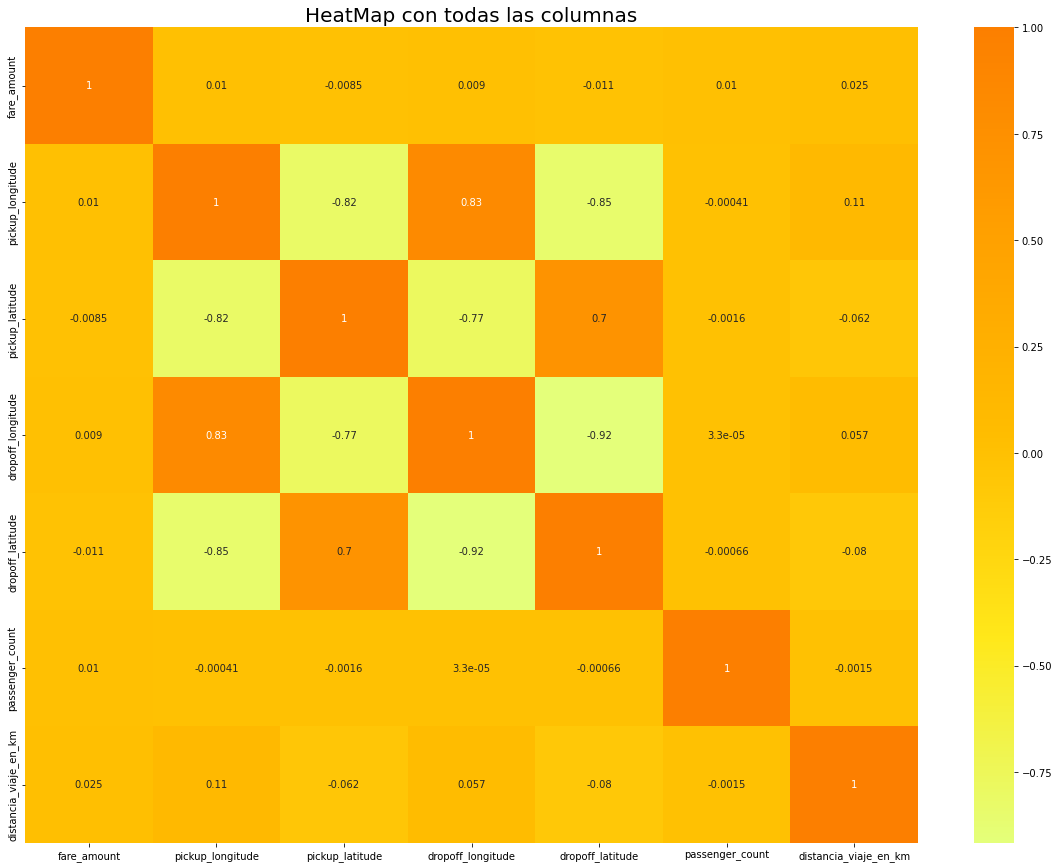

In [26]:
%matplotlib inline
plt.rcParams["figure.figsize"]=(20,15)
sns.heatmap(df.corr(),annot=True,cmap="Wistia")
plt.title("HeatMap con todas las columnas", fontsize=20)

### Me quedo unicamente con las columnas de interes para hacer el mapa de calor 

In [27]:
df.columns.values.tolist()

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'distancia_viaje_en_km']

In [28]:
columnas_interes=["fare_amount","passenger_count","distancia_viaje_en_km"]
df_columnas_interes=df[columnas_interes]

### Verifico que me haya quedado correcto el nuevo DF 

In [29]:
df_columnas_interes.head()

,fare_amount,passenger_count,distancia_viaje_en_km
0,7.5,1,1.683325
1,7.7,1,2.457593
2,12.9,1,5.036384
3,5.3,3,1.661686
4,16.0,5,4.475456


Text(0.5, 1.0, 'HeatMap únicamente con columnas de interés')

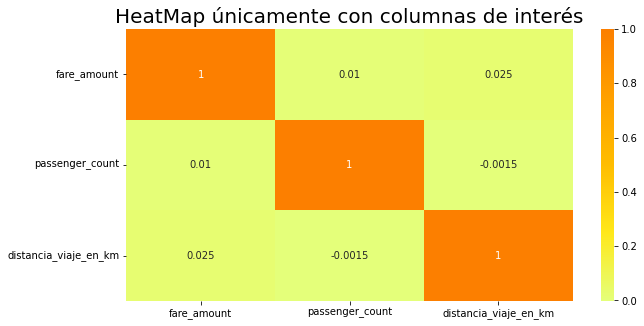

In [30]:
%matplotlib inline
plt.rcParams["figure.figsize"]=(10,5)
sns.heatmap(df_columnas_interes.corr(),annot=True,cmap="Wistia")
plt.title("HeatMap únicamente con columnas de interés", fontsize=20)

No pareciera existir una relación lineal fuerte entre estas variables 

## Hago análisis gráficamente entre las dos situaciones planteadas
    

### Tarifa vs Distancia

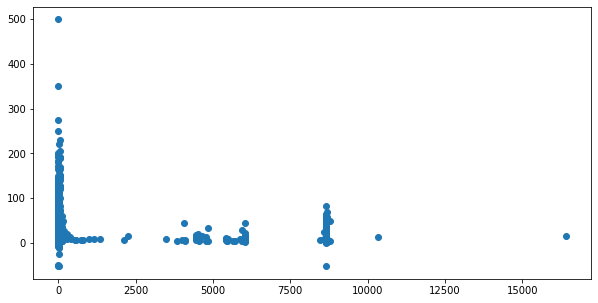

In [31]:
plt.scatter(df_columnas_interes.distancia_viaje_en_km,df_columnas_interes.fare_amount)

Gráficamente se ven valores extraños en la distancia. Busco encontrar la magnitud de estos valores y frecuencia con un histograma

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distancia_viaje_en_km', ylabel='Density'>

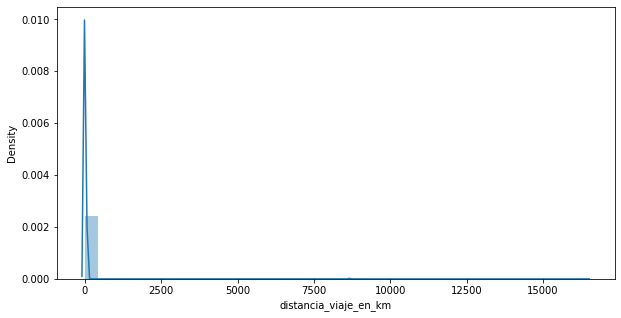

In [32]:
distplot(df_columnas_interes.distancia_viaje_en_km,bins=40)

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='distancia_viaje_en_km'>

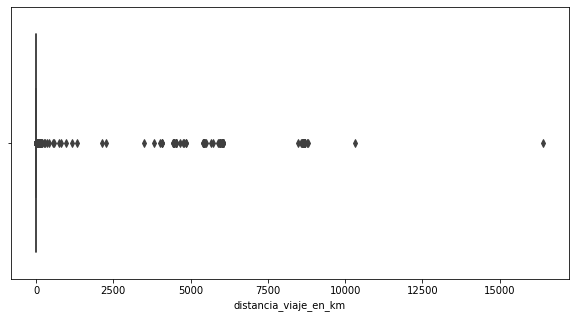

In [33]:
boxplot(df_columnas_interes.distancia_viaje_en_km, orient="v")

Verifico con distancias menor a 2000 km

In [34]:
df_distancias_menores_a_2000km=df_columnas_interes[df_columnas_interes["distancia_viaje_en_km"]<2000]

In [35]:
df_tarifas_menores_a_100.shape

(199888, 8)

Eliminé muy pocos registros, por lo que lo veo correcto e intento gráficar de nuevo.

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='distancia_viaje_en_km'>

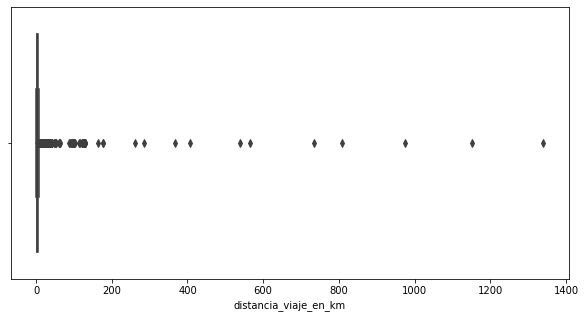

In [36]:
boxplot(df_distancias_menores_a_2000km.distancia_viaje_en_km, orient="v")

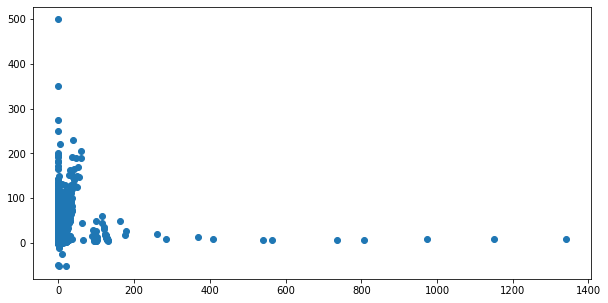

In [37]:
plt.scatter(df_distancias_menores_a_2000km.distancia_viaje_en_km,df_distancias_menores_a_2000km.fare_amount)

Intento haciendo un corte en 200 km

In [38]:
df_distancias_menores_a_200km=df_columnas_interes[df_columnas_interes["distancia_viaje_en_km"]<200]

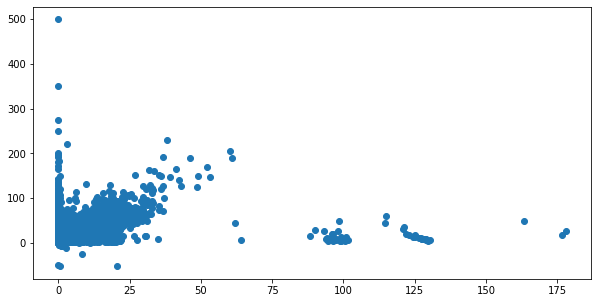

In [39]:
plt.scatter(df_distancias_menores_a_200km.distancia_viaje_en_km,df_distancias_menores_a_200km.fare_amount)

Logro que tenga más sentido pero igualmente, como se había visto en el heatmap, no hay relación lineal entre ambos conceptos.

### Tarifa vs Cantidad de pasajeros

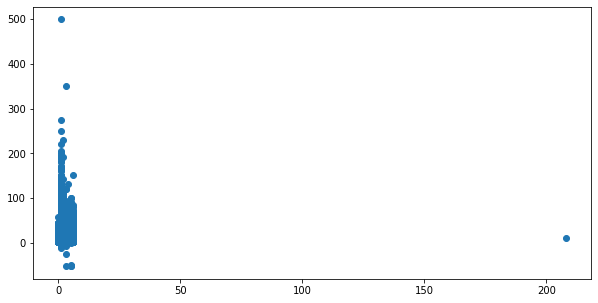

In [40]:
plt.scatter(df_columnas_interes.passenger_count,df_columnas_interes.fare_amount)

Utilizo el DF dónde ya habíamos eliminado el outlier

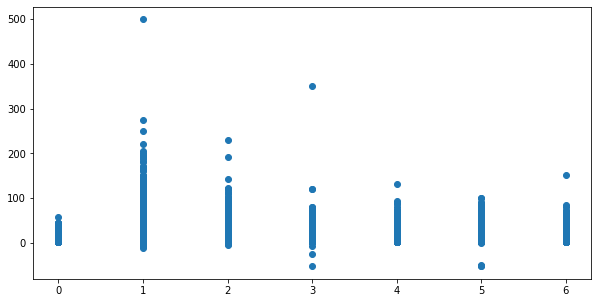

In [41]:
plt.scatter(df_sin_208_pasajeros.passenger_count,df_sin_208_pasajeros.fare_amount)

<AxesSubplot:xlabel='passenger_count', ylabel='fare_amount'>

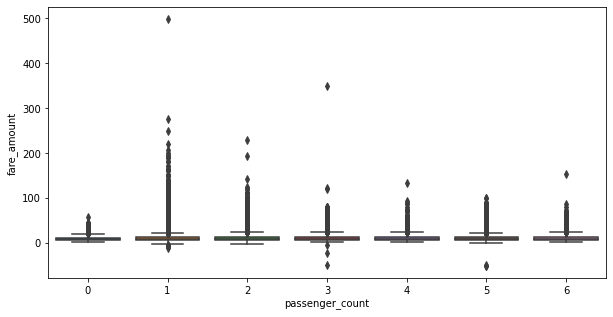

In [42]:
boxplot(x=df_sin_208_pasajeros.passenger_count,y=df_sin_208_pasajeros.fare_amount)

Para ver si tiene más sentido, voy a hacer una tarifa por km (TARIFA/DISTANCIA) y eliminar los outliers de ese dataset

In [43]:
index2= df_columnas_interes.index
index2
tarifa_sobre_distancia=[]
for i in range(len(index2)):
    tarifa=df_columnas_interes.fare_amount[i]
    distancia=df_columnas_interes.distancia_viaje_en_km[i]
    tarifa_sobre_distancia.append(tarifa/distancia)
    tarifa_sobre_distancia

C:\Users\Federico\AppData\Local\Temp/ipykernel_10128/4215018715.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  tarifa_sobre_distancia.append(tarifa/distancia)
C:\Users\Federico\AppData\Local\Temp/ipykernel_10128/4215018715.py:7: RuntimeWarning: invalid value encountered in double_scalars
  tarifa_sobre_distancia.append(tarifa/distancia)


In [44]:
df_columnas_interes["usd_sobre_km"]=tarifa_sobre_distancia

C:\Users\Federico\AppData\Local\Temp/ipykernel_10128/2427204007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_columnas_interes["usd_sobre_km"]=tarifa_sobre_distancia


In [45]:
df_columnas_interes

,fare_amount,passenger_count,distancia_viaje_en_km,usd_sobre_km
0,7.5,1,1.683325,4.455467
1,7.7,1,2.457593,3.133147
2,12.9,1,5.036384,2.561361
3,5.3,3,1.661686,3.189532
4,16.0,5,4.475456,3.575055
...,...,...,...,...
199995,3.0,1,0.112210,26.735490
199996,7.5,1,1.875053,3.999887
199997,30.9,2,12.850337,2.404606
199998,14.5,1,3.539720,4.096369


C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='usd_sobre_km'>

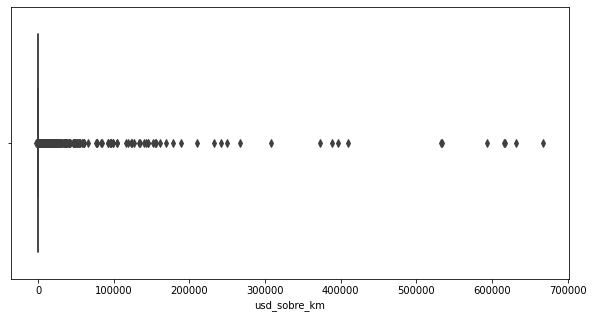

In [46]:
boxplot(df_columnas_interes.usd_sobre_km,orient="v")

Elimino las distancias nulas para que no haga ruido dividiendo

In [47]:
df_columnas_interes_sin_distancias_nulas=df_columnas_interes[df_columnas_interes["distancia_viaje_en_km"]>0]

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='usd_sobre_km', ylabel='Density'>

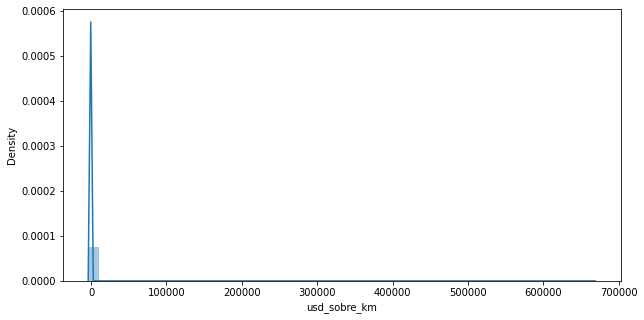

In [48]:
distplot(df_columnas_interes_sin_distancias_nulas.usd_sobre_km)

Le asigno un tope de 1000 usd/km

In [49]:
df_sindistanciasnulas_y_topedeusdsobrekm=df_columnas_interes_sin_distancias_nulas[df_columnas_interes_sin_distancias_nulas["usd_sobre_km"]<2000]

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='usd_sobre_km'>

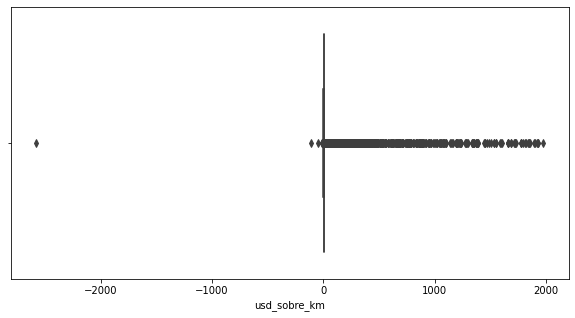

In [50]:
boxplot(df_sindistanciasnulas_y_topedeusdsobrekm.usd_sobre_km)

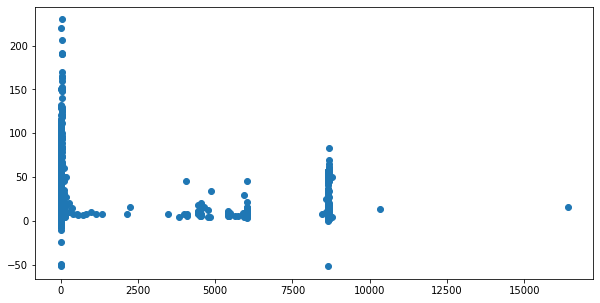

In [51]:
plt.scatter(x=df_sindistanciasnulas_y_topedeusdsobrekm.distancia_viaje_en_km,y=df_sindistanciasnulas_y_topedeusdsobrekm.fare_amount)

Tampoco pareciera haber algúna relación clara entre ambos conceptos.

## Análisis multivariado 

#### A modo de ejemplo para el desafío, voy a analizar las 3 variables:
    . Distancia en Km
    . Cantidad de pasajeros
    . Tarifa

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


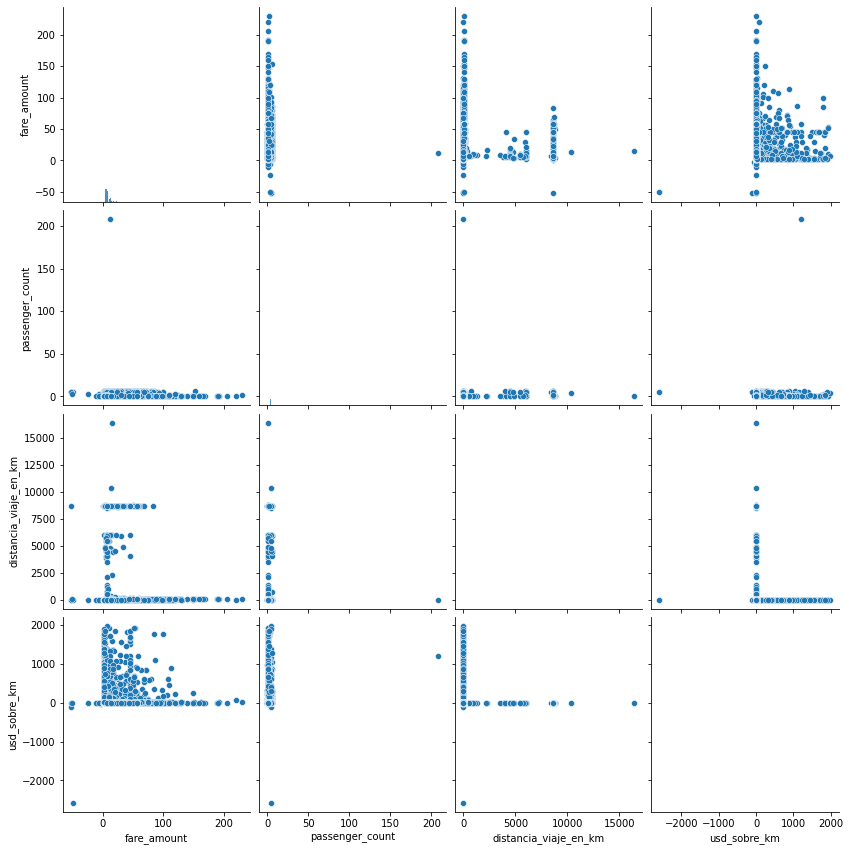

In [52]:
sns.pairplot(df_sindistanciasnulas_y_topedeusdsobrekm, size=3)
plt.show()

Tarifa unitaria vs Distancia

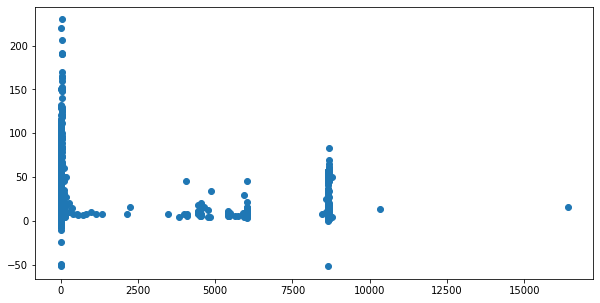

In [53]:
plt.scatter(x=df_sindistanciasnulas_y_topedeusdsobrekm.distancia_viaje_en_km,y=df_sindistanciasnulas_y_topedeusdsobrekm.fare_amount)

Cantidad de pasajeros vs Tarifa

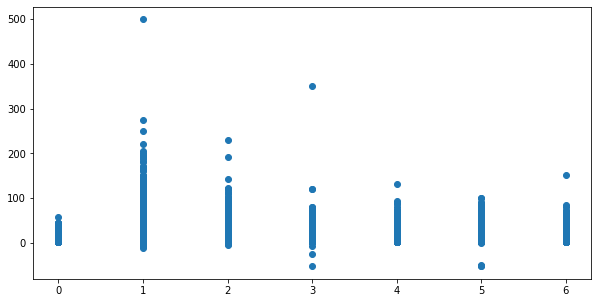

In [54]:
plt.scatter(df_sin_208_pasajeros.passenger_count,df_sin_208_pasajeros.fare_amount)

Haciendo el análisis multivariado, cómo ya se viene observando, hay que seguir trabajando el dataset para poder llegar a conclusiones valiosas para trabajarlo ya que no se puede ver ninguna relación entre variables tal como se tiene hasta ahora.

## Importo nuevamente el Dataset para que no apliquen los cambios hechos sobre el DF durante los diferentes análisis exploratorios

In [55]:
df=pd.read_csv("https://raw.githubusercontent.com/ezequielimeneses/TrabajoFinalDatascientistCoder/9ce01a9d9600daddcd290ab33e5988ebaaf9f6b0/uber.csv")
df=df.iloc[:,1:]
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
199995,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199996,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199997,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199998,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [56]:
distancia=[]
for i in range(len(df.index)):
    punto_salida=df.pickup_latitude[i],df.pickup_longitude[i]
    punto_llegada=df.dropoff_latitude[i],df.dropoff_longitude[i]
    distancia_viaje=haversine(punto_salida,punto_llegada)
    distancia.append(distancia_viaje)
    distancia

In [57]:
df["distancia_viaje_en_km"]=distancia

### Geolocalizo los puntos con el paquete de geopy 

Genero una columna de coordenadas de llegada y coordenadas de salida con tipo string para poder trabajarla con "geolocator" y obtener las ciudades del dataset

In [58]:
df["latitud_salida_string"]=df["pickup_latitude"].astype(str)
df["longitud_salida_string"]=df["pickup_longitude"].astype(str)
df["latitud_llegada_string"]=df["dropoff_latitude"].astype(str)
df["longitud_llegada_string"]=df["dropoff_longitude"].astype(str)
df["coordenadas_salida"]=df.latitud_salida_string+","+df.longitud_salida_string
df["coordenadas_llegada"]=df.latitud_llegada_string+","+df.longitud_llegada_string

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   key                      200000 non-null  object 
 1   fare_amount              200000 non-null  float64
 2   pickup_datetime          200000 non-null  object 
 3   pickup_longitude         200000 non-null  float64
 4   pickup_latitude          200000 non-null  float64
 5   dropoff_longitude        199999 non-null  float64
 6   dropoff_latitude         199999 non-null  float64
 7   passenger_count          200000 non-null  int64  
 8   distancia_viaje_en_km    199999 non-null  float64
 9   latitud_salida_string    200000 non-null  object 
 10  longitud_salida_string   200000 non-null  object 
 11  latitud_llegada_string   200000 non-null  object 
 12  longitud_llegada_string  200000 non-null  object 
 13  coordenadas_salida       200000 non-null  object 
 14  coor

Hay puntos que tienen 0 en las coordenadas. Estos datos debo tratarlos como si fueran NAN y eliminarlos

In [60]:
df.pickup_latitude=df.pickup_latitude[df["pickup_latitude"]!=0]
df.head(20)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,latitud_salida_string,longitud_salida_string,latitud_llegada_string,longitud_llegada_string,coordenadas_salida,coordenadas_llegada
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,40.73835372924805,-73.99981689453125,40.72321701049805,-73.99951171875,"40.73835372924805,-73.99981689453125","40.72321701049805,-73.99951171875"
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457593,40.728225,-73.994355,40.750325,-73.99471,"40.728225,-73.994355","40.750325,-73.99471"
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036384,40.74077,-74.005043,40.772647,-73.962565,"40.74077,-74.005043","40.772647,-73.962565"
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,40.790844,-73.976124,40.803349,-73.965316,"40.790844,-73.976124","40.803349,-73.965316"
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475456,40.744085,-73.925023,40.761247,-73.97308199999999,"40.744085,-73.925023","40.761247,-73.97308199999999"
5,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,40.75591,-73.96901899999999,40.75591,-73.96901899999999,"40.75591,-73.96901899999999","40.75591,-73.96901899999999"
6,2014-10-12 07:04:00.0000002,24.5,2014-10-12 07:04:00 UTC,-73.961447,40.693965,-73.871195,40.774297,5,11.731031,40.693965000000006,-73.96144699999999,40.774297,-73.871195,"40.693965000000006,-73.96144699999999","40.774297,-73.871195"
7,2012-12-11 13:52:00.00000029,2.5,2012-12-11 13:52:00 UTC,0.000000,NaN,0.000000,0.000000,1,0.000000,0.0,0.0,0.0,0.0,"0.0,0.0","0.0,0.0"
8,2012-02-17 09:32:00.00000043,9.7,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1,2.332714,40.745767,-73.975187,40.743537,-74.00272,"40.745767,-73.975187","40.743537,-74.00272"
9,2012-03-29 19:06:00.000000273,12.5,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,40.775012,1,4.889424,40.741787,-74.001065,40.775012,-73.96304,"40.741787,-74.001065","40.775012,-73.96304"


In [61]:
df.dropna(subset=["pickup_latitude"],inplace=True)

In [62]:
df=df.reset_index(drop=True)

In [63]:
df.head(20)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,latitud_salida_string,longitud_salida_string,latitud_llegada_string,longitud_llegada_string,coordenadas_salida,coordenadas_llegada
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,40.73835372924805,-73.99981689453125,40.72321701049805,-73.99951171875,"40.73835372924805,-73.99981689453125","40.72321701049805,-73.99951171875"
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457593,40.728225,-73.994355,40.750325,-73.99471,"40.728225,-73.994355","40.750325,-73.99471"
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036384,40.74077,-74.005043,40.772647,-73.962565,"40.74077,-74.005043","40.772647,-73.962565"
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,40.790844,-73.976124,40.803349,-73.965316,"40.790844,-73.976124","40.803349,-73.965316"
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475456,40.744085,-73.925023,40.761247,-73.97308199999999,"40.744085,-73.925023","40.761247,-73.97308199999999"
5,2011-02-12 02:27:09.0000006,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,40.75591,-73.96901899999999,40.75591,-73.96901899999999,"40.75591,-73.96901899999999","40.75591,-73.96901899999999"
6,2014-10-12 07:04:00.0000002,24.5,2014-10-12 07:04:00 UTC,-73.961447,40.693965,-73.871195,40.774297,5,11.731031,40.693965000000006,-73.96144699999999,40.774297,-73.871195,"40.693965000000006,-73.96144699999999","40.774297,-73.871195"
7,2012-02-17 09:32:00.00000043,9.7,2012-02-17 09:32:00 UTC,-73.975187,40.745767,-74.002720,40.743537,1,2.332714,40.745767,-73.975187,40.743537,-74.00272,"40.745767,-73.975187","40.743537,-74.00272"
8,2012-03-29 19:06:00.000000273,12.5,2012-03-29 19:06:00 UTC,-74.001065,40.741787,-73.963040,40.775012,1,4.889424,40.741787,-74.001065,40.775012,-73.96304,"40.741787,-74.001065","40.775012,-73.96304"
9,2015-05-22 17:32:27.0000004,6.5,2015-05-22 17:32:27 UTC,-73.974388,40.746952,-73.988586,40.729805,1,2.250861,40.74695205688477,-73.9743881225586,40.729804992675774,-73.98858642578125,"40.74695205688477,-73.9743881225586","40.729804992675774,-73.98858642578125"


In [64]:
ciudades_salida=[]
for i in range(0,1000):
    location=geolocator.reverse(df.coordenadas_salida[i],timeout=None)
    if location is None:
        ciudades_salida.append("Sin datos")
    else:
        address=location.raw["address"]
        ciudad=address.get("city")
        ciudades_salida.append(ciudad)

Como es muy pesado de procesar geográficamente los 200.000 registros, tomé como solución de compromiso el marcar un cuadrado limitando los puntos que se encuentran dentro de allí cómo si fuera NY

In [65]:
latitud_ny_salida=(df["pickup_latitude"]>40.495898)&(df["pickup_latitude"]<40.911288)
latitud_ny_llegada=(df["dropoff_latitude"]>40.495898)&(df["dropoff_latitude"]<40.911288)
longitud_ny_salida=(df["pickup_longitude"]>-74.257124)&(df["pickup_longitude"]<-73.700942)
longitud_ny_llegada=(df["dropoff_longitude"]>-74.257124)&(df["dropoff_longitude"]<-73.700942)


In [66]:
df["latitud_ny_salida"]=latitud_ny_salida
df["latitud_ny_llegada"]=latitud_ny_llegada
df["longitud__ny_salida"]=longitud_ny_salida
df["longitud_ny_llegada"]=longitud_ny_llegada

In [67]:
df.shape

(196218, 19)

In [68]:
df=df[df["latitud_ny_salida"] == True]
df=df[df["latitud_ny_llegada"] == True]
df=df[df["longitud__ny_salida"] == True]
df=df[df["longitud_ny_llegada"] == True]

La distancia máxima en auto dentro de NYC es de 96,5606 km por lo que filtro los registros dentro de esa rango

In [69]:
distancia_entre0y96km=(df["distancia_viaje_en_km"]>0)&(df["distancia_viaje_en_km"]<96.5606)

In [70]:
df["distancia_entre0y96km"]=distancia_entre0y96km
df=df[df["distancia_entre0y96km"] == True]
df.shape

(193557, 20)

Me quedo solo con tarifas positivas (mayores a 0)

In [71]:
tarifa_mayora0=(df["fare_amount"]>0)
df["tarifa_mayora0"]=tarifa_mayora0
df=df[df["tarifa_mayora0"] == True]
df.shape

(193539, 21)

Convierto al formato correcto la columna de "pickup_datetime" para poder trabajar con la hora y fecha de dicha columna

In [72]:
df["pickup_datetime"]=pd.to_datetime(df["pickup_datetime"])

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193539 entries, 0 to 196217
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   key                      193539 non-null  object             
 1   fare_amount              193539 non-null  float64            
 2   pickup_datetime          193539 non-null  datetime64[ns, UTC]
 3   pickup_longitude         193539 non-null  float64            
 4   pickup_latitude          193539 non-null  float64            
 5   dropoff_longitude        193539 non-null  float64            
 6   dropoff_latitude         193539 non-null  float64            
 7   passenger_count          193539 non-null  int64              
 8   distancia_viaje_en_km    193539 non-null  float64            
 9   latitud_salida_string    193539 non-null  object             
 10  longitud_salida_string   193539 non-null  object             
 11  latitud_llega

Obtengo 4 rangos horarios significativos para poder trabajar mejor con la hora

In [74]:
df=df.reset_index(drop=True)

In [75]:
rango_horario=[]
for i in range(len(df.index)):
    hora_viaje=df.pickup_datetime[i].hour
    if hora_viaje < 6:
        rango_horario.append("Madrugada")
    elif hora_viaje < 12:
        rango_horario.append("Mañana")
    elif hora_viaje < 19:
        rango_horario.append("Tarde")
    else:
        rango_horario.append("Noche")  
    
        

In [76]:
df["rango_horario"]=rango_horario

Agrego información al dataset viendo qué dia de la semana son los viajes y si estos son fin de semana o no

In [77]:
nro_dia_semana=[]
for i in range(len(df.index)):
    dia_semana=df.pickup_datetime[i].weekday()
    nro_dia_semana.append(dia_semana)


In [78]:
df["nro_dia_semana"]=nro_dia_semana

In [79]:
fin_de_semana=[]
for i in range(len(df.index)):
    dia_semana=df.pickup_datetime[i].weekday()
    if dia_semana < 5:
        fin_de_semana.append("Entre semana")
    else:
        fin_de_semana.append("Fin de semana")  

In [80]:
df["fin_de_semana"]=fin_de_semana

Finalmente, me quedo únicamente con las columnas de interés para el análisis, descartando las columnas creadas con el objetivo de hacer el data wrangling

In [81]:
columnas_interes=["fare_amount","pickup_datetime","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","passenger_count","distancia_viaje_en_km","coordenadas_salida","coordenadas_llegada","rango_horario","nro_dia_semana","fin_de_semana"]
df=df[columnas_interes]

In [82]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distancia_viaje_en_km,coordenadas_salida,coordenadas_llegada,rango_horario,nro_dia_semana,fin_de_semana
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683325,"40.73835372924805,-73.99981689453125","40.72321701049805,-73.99951171875",Noche,3,Entre semana
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457593,"40.728225,-73.994355","40.750325,-73.99471",Noche,4,Entre semana
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036384,"40.74077,-74.005043","40.772647,-73.962565",Noche,0,Entre semana
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661686,"40.790844,-73.976124","40.803349,-73.965316",Mañana,4,Entre semana
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475456,"40.744085,-73.925023","40.761247,-73.97308199999999",Tarde,3,Entre semana
